### CASA0002

# Urban Simulation
***
## Agent Based Modelling

Mateo Neira
***

In this lab, we will go over a practical implementation of an agent-based model in python. We will be using [MESA](https://pypi.org/project/Mesa/), an agent-based modelling framework for python. There are numerous software and frameworks for agent-based-modelling, such as NetLogo or Repast. We have decided to show the practical implementation in python to remain consistent with the rest of the module’s contents. The main objective is to introduce important considerations when running these types of models and analyse results from these. Don't worry too much about the technical aspects of the model implementation, but rather in the concepts and analysis.

For those of you who are interested in setting up your own ABM's, you can check out [MESA's Documentation on specifying a model](https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html). 

## Resources

---

* **Online video-course from the Complexity Explorer (Santa Fe Institute)**: [Intro to ABM by William Rand](https://www.complexityexplorer.org/courses/101-introduction-to-agent-based-modeling-spring-2020)
* **Agent Based Modeling paper**: ["Agent Based Modeling and Simulation:
An Informatics Perspective". Stefania Bandini, Sara Manzoni and Giuseppe Vizzari
(2009), Journal of Artificial Societies and Social Simulation 12 (4) 4](http://jasss.soc.surrey.ac.uk/12/4/4.html)
* **Agent-Based Models and urban form**: ["Modelling spatial morphologies: Fractal patterns from cellular
automata.". Batty, Michael, and Paul A. Longley. (2014)](https://www.taylorfrancis.com/chapters/modelling-spatial-morphologies-fractal-patterns-cellular-automata-robert-abrahart-linda-see/10.1201/b17091-9)

## What is a Model?

* Abstracted description of a process, object or event
* Exaggerates certain aspects at the expense of others

## What is an Agent Based Model?

* A model composed of **agents**
    * Autonomous individual element with **properties** and **actions**
* Composed of:
    * Environment
    * Agents
    * Description of **agent-agent** and **agent-environment** interactions

### The basics of a multi-agent system

![](flock.gif)

Agent-based models are models that allow heterogeneity (in contrast to mean-field or statistical approaches). In these types of models, there is no central control, agents are autonomous and can interact with other agents and the environment. Individual behaviours of the agents are aggregated into global mechanisms (for example flocking behaviour).

There are two main design strategies for ABM:

* **Phenomena-based modelling**: the characteristic patterns that we want to model are known.
    * object is to find a set of agents and rules that will generate the know reference pattern
* **Exploratory modelling**: built using a bottom-up approach. We start with a basic set of mechanisms and explore the results
    * cellular automata is an example



### Agent-Based Models in Geographical and Urban Systems

**What are the consequences of individual behaviours and decision-making over space and time?**

---
    
In this practical we will be focusing on implementing Schelling's model of segregation. The model was developed by the economist Thomas Schelling and is one of the earliest examples of agent-based models, which contain:

* Autonomous agents interacting in a shared environment
* Emergent global patterns from local interactions and decisions



### Dynamic models of segregation

Schelling's Segregation model was proposed in 1971 in his paper ["Dynamic models of segregation"](https://www.tandfonline.com/doi/abs/10.1080/0022250X.1971.9989794). The model consists of Agents that can belong to one of two groups (A or B) and occupies a space in a $N \times N$ grid. Each agent has a preference for how many neighbours must be of its same group for it to be happy. Unhappy agents pick a new random location to relocate until they are happy. The model runs until there are no more unhappy agents. 

The model demostrates how even mild preferences for similar neighbours can result in high degree of segregation

Before getting started we need to install MESA into our environment. We can do this directly from jupyter notebook by using the magic command '!'  and providing '-y' to specify yes to the install prompt as you can not submit input to the commands when running.

> ! conda install mesa -y

The installation should be fairly quick, as the framework is not to heavy and has few dependencies.

In [ ]:
!conda install mesa -y

In [2]:
#now that we have mesa installed we can import the required components
from mesa import Agent, Model #class for specifying agents and model
from mesa.space import SingleGrid 
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

#for visualization purposes
from mesa.visualization.ModularVisualization import ModularServer 
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.UserParam import UserSettableParameter
import matplotlib.pyplot as plt
import seaborn as sns

## Setting up the model

We will be using the two core classes that we imported previously: 
* **Agent**: which specifies the agents
* **Model**: which holds model-level attributes and manages the agents

The **Model** will be specified by:
* size of world given by a height and a width
* population density
* agent threshold which defines how many similar neighbours are required for the agents to be happy
* percentage of minority group

## The Agents

We will start by specifing the agents in our model. We will do this by creating our own agents class that will inheret from the Agents class from the MESA library. 

We need our agents to have two variables:
* position: this will be the x,y coordinates related to the location of the agent in our grid world.
* group: each agent can belong to one of two groups (1,0)

And we need our agents to be able to do three things:
* check what group their neighbours belong to.
* determine if they are happy with their location
* move to an empty cell if they are not happy

In [3]:
class SchellingAgent(Agent):
    """
    here we define the parameters that the agent will have
    each agent will have a position which specifies its location in the grid
    and a type, which specifies which group it belongs to
    """
    
    def __init__(self, pos, model, group):
        super().__init__(pos, model)
        #create variables we need
        self.pos = pos
        self.group = group
        
        #additional variables needed
        #to calculate segregation and happiness
        self.similar_neighbours = 0.0
        self.total_neighbours = 0.0
        self.happy = False
    
    def step(self):
        """
        here we specify what each agent does in each model iteration
        essentially its a function that calculates number of similar neighbours
        moves the agent to a different empty location if the number of similar neighbours is bellow its treshold
        """

        #calculate number of similar neighbours
        self.similar_neighbours = 0
        self.total_neighbours = 0
        
        #we iterate through the neighbours of the agent
        for neighbour in self.model.grid.neighbor_iter(self.pos):
            #if neighbour is the same as the agent add one to similar_neighbour
            if neighbour.group == self.group:
                self.similar_neighbours +=1
            #count number of neighbours by adding 1 to total_neighbourhood    
            self.total_neighbours +=1
        
        #check if number of similar neighbours is bellow threshold
        if self.similar_neighbours <= self.model.threshold * self.total_neighbours:
            #move agent to empty grid
            self.model.grid.move_to_empty(self)
        else:
            #report happy agent to model
            self.happy = True

## The Model

The model is a little bit more complicated to setup as it is composed of three different components:
* **space**: the world were the agents will live
* **agents**: the agents that occupy the world
* **scheduler**: how the agents update their states 

### Space

There are different types of spaces:

* **Continuous spaces**: here each agent can occupy any arbitrary position, neighbours are defined according to distances betweeen agents (radius)

* **Discrete spaces**: each agent can occupy only specific places on the space (for example a cell in a grid). Neighbours are defined by adjacency in the discrete space.
    * Grid space
    * Network space

Each one of these types can also have different topologies. The topology of a space essentially defines how neighbours are defined at the 'borders' of the space.
* Finite/infine planar spaces: cartesian spaces of any dimension
* Toroidal space
* Spherical space

In our Schelling model we will be using a discrete toroidal space. We can easily do this with MESA:

```python
from mesa.space import SingleGrid
grid = SingleGrid(size[0], size[1], torus=True)
```

### Scheduler

Time in most agent-based models moves in steps, sometimes also called ticks. At each time step agents are activated, take actions, or change internal states. How agents are activated at each time step is an important design decision when specifing our models. The scheduler takes care of this task.

schedueler handles how agents update their states.
* synchronous: all agents update their state at the same time 
* asynchronous: agents update sequentially, of at different times


In our case we will be updating the agents asynchronously
```python
from mesa.time import RandomActivation

schedule = RandomActivation(model)
```

In [4]:
# we put this all together in our model class
#similar to agents, we inheret from mesa.Model class
class Schelling(Model):
    def __init__(self, size, density, percent_minority, threshold):
        #setup initial variables
        self.size =  size
        self.density = density
        self.percent_minority = percent_minority
        self.threshold = threshold
        
        #create grid
        self.grid = SingleGrid(size[0], size[1], torus=True)
        
        #create schedueler to manage agents
        self.schedule = RandomActivation(self)
        
        #setup the data collector to gather information about all agents
        self.datacollector = DataCollector(
            {'happy': lambda m: self.happy(),
             'segregation': lambda m: self.segregation(),
            },
            {'x': lambda a: a.pos[0], 
             'y': lambda a: a.pos[1],
             'num_similar': lambda a: a.similar_neighbours,
             'total_neighbours':lambda a: a.total_neighbours
            }
        )
        
        #setup agents by iterating through the grid and placing agents at random
        for cell in self.grid.coord_iter():
            #each sell is a tuple with 3 values (agent, x, y)
            x = cell[1]
            y = cell[2]
            
            #add agents according to density
            if self.random.random() < self.density:
                if self.random.random() < self.percent_minority:
                    agent_group = 1
                else:
                    agent_group = 0 
            
                #initiate an agent at position in grid
                agent = SchellingAgent((x,y), self, agent_group)
                
                #add agent to grid
                self.grid.position_agent(agent, (x,y))
                
                #add agent to scheduler
                self.schedule.add(agent)
            
        self.running = True
        self.datacollector.collect(self)
        
    def step(self):
        self.schedule.step()
        
        self.datacollector.collect(self)
        
        if self.happy() == 1.0:
            self.running = False
    
    def happy(self):
        '''
        Helper method to measure percent of happy agents
        ''' 
        happy = 0 
        for agent in self.schedule.agents:
            if agent.happy:
                happy +=1
        return happy / self.schedule.get_agent_count()
            
    def segregation(self):
        '''
        Helper method to measure total segregation
        '''
        segregation  = 0
        for agent in self.schedule.agents:
            if agent.total_neighbours !=0:
                segregation += agent.similar_neighbours / agent.total_neighbours
        return segregation / self.schedule.get_agent_count()

Now thats our model! 

we can run this quickly and see if its all working 

```python
model = Schelling((10,10), 0.8,0.5,0.3)
```

In [12]:
#we instantiate our model with the parameters of interest 
model = Schelling((20,20), 0.8,0.5,0.3)

#we run our model
#notice we run it in a while loop
#this is because in some cases, our model may not converge
#(no matter how long we run the model, not all agents will ever be happy!)

while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps) # Show how many steps have actually run

6


In [13]:
#we can call the model to get outputs
total_agents = model.schedule.get_agent_count()
perc_happy = model.happy()

print(f'{total_agents} agents')
print(f'of which {perc_happy * 100:.0f}% are happy')
print(f'total segregation: {model.segregation()*100:.2f}%')

321 agents
of which 100% are happy
total segregation: 69.25%


In [14]:
model_out = model.datacollector.get_model_vars_dataframe()
model_out.head()

,happy,segregation
0,0.000000,0.000000
1,0.828660,0.531305
2,0.965732,0.626057
3,0.984424,0.654521
4,0.996885,0.675512


In [15]:
agent_out = model.datacollector.get_agent_vars_dataframe()
agent_out

x   y  num_similar  total_neighbours
Step AgentID                                        
0    (0, 1)    19   4          0.0               0.0
     (0, 2)    14   7          0.0               0.0
     (0, 3)     7  16          0.0               0.0
     (0, 4)     0  15          0.0               0.0
     (0, 6)     1   0          0.0               0.0
...            ..  ..          ...               ...
6    (19, 14)   6   9          4.0               5.0
     (19, 15)   3  14          5.0               7.0
     (19, 16)  18   5          5.0               5.0
     (19, 18)   8   0          5.0               8.0
     (19, 19)  10   8          3.0               4.0

[2247 rows x 4 columns]

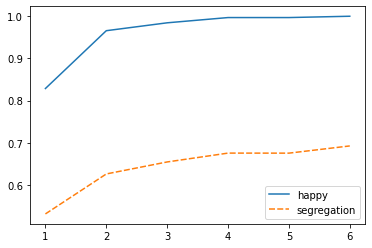

In [16]:
sns.lineplot(data=model_out.iloc[1:])
plt.show()

MESA has a great functions for creating an interactive environment.

I wont get into the details here, but do feel free to [check out MESA advanced tutorial](https://mesa.readthedocs.io/en/master/tutorials/adv_tutorial.html) if you are interested in diving in further.

In [17]:
class OutElement(TextElement):
    def __init__(self):
        pass
    
    def render(self, model):
        return f"Happy agents: {model.happy()*100:.1f}% \n Segregation: {model.segregation()*100:.1f}%"
    
def schelling_draw(agent):
    if agent is None:
        return
    portrayal = {"Shape": "circle", "r": 0.5, "Filled": "true", "Layer": 0}

    if agent.group == 0:
        portrayal["Color"] = "#FF9999"
        portrayal["stroke_color"] = "#000000"
    else:
        portrayal["Color"] = "#9999FF"
        portrayal["stroke_color"] = "#000000"
    return portrayal


out_element = OutElement()
canvas_element = CanvasGrid(schelling_draw, 40, 40, 500, 500)
happy_chart = ChartModule([{"Label": "happy", "Color": "Black"}], canvas_height=150)


model_params = {
    "size": (40,40),
    "density": UserSettableParameter("slider", "Agent density", 0.8, 0.1, 1.0, 0.05),
    "percent_minority": UserSettableParameter("slider", "Percent minority", 0.5, 0.00, 1.0, 0.05),
    "threshold": UserSettableParameter("slider", "Threshold", 0.3, 0, 1, 0.05)
}


server = ModularServer(Schelling,
                       [canvas_element, out_element, happy_chart],
                       "Schelling", model_params)

In [18]:
server.port = 8021 # The default
server.launch()

Interface starting at http://127.0.0.1:8021


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"reset"}


## Analysing results

As you can see from the model, even if individual agents do not have a preference for a segregated outcome (are happy to be the minority in the neighbourhood), the aggregate results turn out to be heavily segregated. 

This is a classic example of emergence of qualitatively different micro-level outcomes from agents following simple rules. 

---

Now, even though the graphical interface can be a useful tool to understand how the model works, check that it's functioning as we would expect, and build intuition about the dynamics at play, we need to understand how the model behaves given different parameters (sensitivity to initial conditions), as well as account for randomness by looking at the average behaviour of multiple runs.

In [19]:
from mesa.batchrunner import BatchRunner

In [24]:
def get_happy(model):
    return model.happy()

def number_agents(model):
    return model.schedule.get_agent_count()

def get_segregation(model):
    return model.segregation()

In [34]:
parameters = {"size": [(10,10)], "density": [0.8], "percent_minority": [0.5], 
              "threshold": [x/100 for x in range(5,100,5)]}

model_reporters = {"segregation": get_segregation, 'happy': get_happy, 'num_agents': number_agents}

param_sweep = BatchRunner(Schelling, variable_parameters= parameters, iterations=20, max_steps=100, model_reporters=model_reporters)

param_sweep.run_all()

380it [00:25, 15.14it/s]


In [35]:
df = param_sweep.get_model_vars_dataframe()
df.head()

,density,size,percent_minority,threshold,Run,happy,num_agents,segregation
0,"(10, 10)",0.8,0.5,0.05,0,1.0,90,0.457646
1,"(10, 10)",0.8,0.5,0.05,1,1.0,77,0.531339
2,"(10, 10)",0.8,0.5,0.05,2,1.0,77,0.501237
3,"(10, 10)",0.8,0.5,0.05,3,1.0,80,0.506607
4,"(10, 10)",0.8,0.5,0.05,4,1.0,77,0.550232


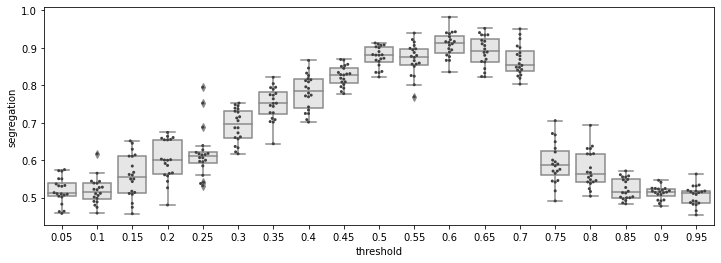

In [39]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,4))

ax =  sns.boxplot(data= df, x = 'threshold', y = 'segregation', color=".9")
ax = sns.swarmplot(data= df, x = 'threshold', y = 'segregation', color=".25", size=3)

plt.show()

C:\Users\malvarez\AppData\Local\Continuum\miniconda3\envs\urbsim\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 55.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\malvarez\AppData\Local\Continuum\miniconda3\envs\urbsim\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


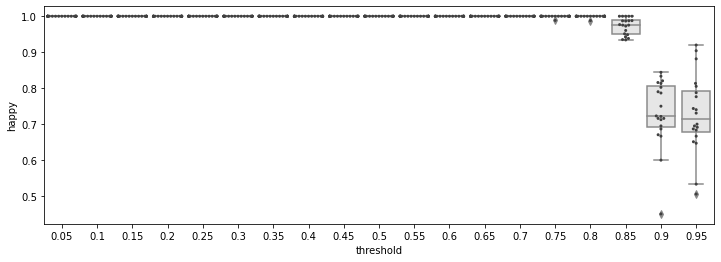

In [40]:
fig, ax = plt.subplots(figsize=(12,4))
ax =  sns.boxplot(data= df, x = 'threshold', y = 'happy', color=".9")
ax = sns.swarmplot(data= df, x = 'threshold', y = 'happy', color=".25", size=3)
plt.show()

## Important considerations

* Verification: making sure your model does what you think it does
* Validation: making sure your model corresponds to the real world in some meaningful way
* Replication: making sure your model can be replicated and the results can be repeated


### Possible extensions to think about in your free time

* what happens whe you change the density of the world?
* what happens if we add variance to the threshold of each agent?

### References

* MESA reference: https://mesa.readthedocs.io/en/master/tutorials/intro_tutorial.html#tutorial-description
* Original Schelling model paper: https://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf